## Introduction
In this analysis, we will have a look at how to analyze food prices in difefrent locations, view elements of seasonaity in food prices and possible alternative sources of commodities in the supply chain. 

The analysis analyzes data using libraries in the geospatial space such as Geopandas, Folium, CountryInfo and PyCountry. For viisualization, we're using matplotlib, plotly, and seaborn. 

For analysis purposes, we will look at 1 specific country - Afghanistan, and 1 specific commodity - Retail Wheat. There's a data pipeline at the end that can be used to reproduce the analysis for every counry and/or commodity in the dataset.

There's also an element of time series forecasting, so stay tuned for that as well. 

## Datasets
The dataset being analyzed is from [Humdata](https://data.humdata.org/dataset/wfp-food-prices).
This dataset contains Global Food Prices data from the World Food Programme covering foods such as maize, rice, beans, fish, and sugar for 76 countries and some 1,500 markets. It is updated weekly but contains to a large extent monthly data. The data goes back as far as 1992 for a few countries, although many countries started reporting from 2003 or thereafter.
Additional datasets include 
- ne_10m_admin_0_countries.shp which has the shape file of the Admin 0 Countries. Each country is coded with a world region that roughly follows the United Nations setup.
- naturalearth_lowres ageopandas dataset 

## Questions
Questions to answer in this analyss include:
1. Of the countries that sell retail wheat, how do their prices compare in the most recent year?
2. For the selected country (Afghanistan) and commodity (Wheat-Retail), what bhavior can be observed?
3. How does the price of the commodity compare to other countries selling it over time?
4. What is an alternative source of the commodity for the select country?
5. What additional information can be helpful to forecast the price of the commodity in the next month? year? 5 years?

In [1]:
# Import necessary libraries

import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
from pandas.api.types import CategoricalDtype
import folium
import geopandas as gpd
from countryinfo import CountryInfo
import pycountry
from branca.colormap import linear
from IPython.display import display
import warnings

warnings.filterwarnings('ignore')

# Show visuals
%matplotlib inline

# Set background of graphs to darkgrid
sns.set_style("darkgrid")

In [2]:
# Read dataset

df = pd.read_csv('wfpvam_foodprices.csv')

## Data Exploration

In [3]:
# View first 5 rows
df.head()

,adm0_id,adm0_name,adm1_id,adm1_name,mkt_id,mkt_name,cm_id,cm_name,cur_id,cur_name,pt_id,pt_name,um_id,um_name,mp_month,mp_year,mp_price,mp_commoditysource
0,1.0,Afghanistan,272,Badakhshan,266,Fayzabad,55,Bread - Retail,0.0,AFN,15,Retail,5,KG,1,2014,50.0,NaN
1,1.0,Afghanistan,272,Badakhshan,266,Fayzabad,55,Bread - Retail,0.0,AFN,15,Retail,5,KG,2,2014,50.0,NaN
2,1.0,Afghanistan,272,Badakhshan,266,Fayzabad,55,Bread - Retail,0.0,AFN,15,Retail,5,KG,3,2014,50.0,NaN
3,1.0,Afghanistan,272,Badakhshan,266,Fayzabad,55,Bread - Retail,0.0,AFN,15,Retail,5,KG,4,2014,50.0,NaN
4,1.0,Afghanistan,272,Badakhshan,266,Fayzabad,55,Bread - Retail,0.0,AFN,15,Retail,5,KG,5,2014,50.0,NaN


In [4]:
# Add date column as start of month
# Convert 'mp_month' column to string and zero-pad single-digit months
df['mp_month'] = df['mp_month'].astype(str).str.zfill(2)
df['mp_year'] = df['mp_year'].astype(str).str.zfill(2)
# Combine 'mp_month' and 'mp_year' columns
df['start_of_month'] = pd.to_datetime(df['mp_month'] + df['mp_year'], format='%m%Y')
df['start_of_month'] = df['start_of_month'].dt.to_period('M').dt.to_timestamp()

In [5]:
# um_name column has metrics of the pricing of commodities. To see the different metrics if any,
df.um_name.unique()

array(['KG', 'Day', 'Unit', 'L', 'USD/LCU', '30 pcs', '500 G', '125 G',
       'Packet', '900 G', '50 Pounds', '100 KG', '46 KG', '11.5 KG',
       'Pound', 'Cuartilla', 'Libra', '5 L', '10 pcs', '90 KG', '1 piece',
       '400 G', '15 KG', '5 KG', '12 KG', '20 KG', '120 KG', '20 L',
       '18 KG', '50 KG', '160 KG', '1.5 L', 'Sack', 'Package', 'Head',
       'MT', '85 G', 'Gallon', '380 G', '500 ML', 'Month', 'Course',
       '100 Pounds', '168 G', '45 KG', '70 G', '200 G', '68 KG', '109 KG',
       '91 KG', '93 KG', '10 KG', 'Bunch', '250 KG', '100 Tubers',
       '73 KG', '84 KG', '52 KG', '27 KG', '16 KG', '650 G', '750 ML',
       '115 G', '360 pcs', '50 pcs', '100 pcs', 'Marmite', '350 G',
       '385 G', '1.8 KG', 'Cylinder', '4 pcs', '150 ml', '2 KG', '1.8 L',
       '170 G', '1.5 KG', '300 G', '0.8 KG', '160 G', '750 G', '12.5 KG',
       '200 ML', '150 G', '1.3 KG', '185 G', 'Loaf', '2.25 KG', '5 pcs',
       '250 G', '11 KG', 'Brush', '100 ML', 'Bar', '250 ML', 'Pile',
    

There's the need to standardize the pricing across the dataset. To do this, we need to get separate the quantity and metric, then convert the the price to that of a unit metric.

In [6]:
# Initialize new columns
um_quantity = []
um_metric = []

# Iterate over each value
for value in df.um_name:
    # Extract numeric value using regular expression
    quantity = re.findall(r'\d+(?:\.\d+)?', value)
    if quantity:
        um_quantity.append(float(quantity[0]))
    else:
        um_quantity.append(1)
    
    # Extract unit using regular expression
    metric = re.sub(r'\d+(?:\.\d+)?', '', value).strip()
    um_metric.append(metric)

# Add new columns to existing DataFrame
df['um_quantity'] = um_quantity
df['um_metric'] = um_metric

In [7]:
# Standardize quantity

df['updated_quantity'] = np.where(df.um_metric.isin(['g', 'G']), df.um_quantity / 1000, df.um_quantity)
df['updated_quantity'] = np.where(df.um_metric.isin(['ml', 'ML']), df.um_quantity / 1000, df.um_quantity)
df['updated_metric'] = np.where(df.um_metric.isin(['g', 'G']), 'KG', np.where(df.um_metric.isin(['ml', 'ML']), 'L', df.um_metric))


In [8]:
# Calculate price per unit/metric
df['mp_price_pu'] = df['mp_price'] / df['updated_quantity'] 

df.head()

,adm0_id,adm0_name,adm1_id,adm1_name,mkt_id,mkt_name,cm_id,cm_name,cur_id,cur_name,...,mp_month,mp_year,mp_price,mp_commoditysource,start_of_month,um_quantity,um_metric,updated_quantity,updated_metric,mp_price_pu
0,1.0,Afghanistan,272,Badakhshan,266,Fayzabad,55,Bread - Retail,0.0,AFN,...,01,2014,50.0,NaN,2014-01-01,1.0,KG,1.0,KG,50.0
1,1.0,Afghanistan,272,Badakhshan,266,Fayzabad,55,Bread - Retail,0.0,AFN,...,02,2014,50.0,NaN,2014-02-01,1.0,KG,1.0,KG,50.0
2,1.0,Afghanistan,272,Badakhshan,266,Fayzabad,55,Bread - Retail,0.0,AFN,...,03,2014,50.0,NaN,2014-03-01,1.0,KG,1.0,KG,50.0
3,1.0,Afghanistan,272,Badakhshan,266,Fayzabad,55,Bread - Retail,0.0,AFN,...,04,2014,50.0,NaN,2014-04-01,1.0,KG,1.0,KG,50.0
4,1.0,Afghanistan,272,Badakhshan,266,Fayzabad,55,Bread - Retail,0.0,AFN,...,05,2014,50.0,NaN,2014-05-01,1.0,KG,1.0,KG,50.0


In [9]:
df.shape

(2050638, 24)

In [10]:
df.um_metric.unique()

array(['KG', 'Day', 'Unit', 'L', 'USD/LCU', 'pcs', 'G', 'Packet',
       'Pounds', 'Pound', 'Cuartilla', 'Libra', 'piece', 'Sack',
       'Package', 'Head', 'MT', 'Gallon', 'ML', 'Month', 'Course',
       'Bunch', 'Tubers', 'Marmite', 'Cylinder', 'ml', 'Loaf', 'Brush',
       'Bar', 'Pile', 'Heap', 'Dozen', 'Bundle', 'LCU/kg', 'Cubic meter',
       'Pair', 'GB', 'kWh'], dtype=object)

#### 1. Visualize countries selling retail wheat

In [11]:
# Generate country code  based on country name 
import pycountry 
def alpha3code(column):
    CODE=[]
    for country in column:
        try:
            code=pycountry.countries.get(name=country).alpha_3
           # .alpha_3 means 3-letter country code 
           # .alpha_2 means 2-letter country code
            CODE.append(code)
        except:
            CODE.append('None')
    return CODE
# Create a column for the alpha code 
df['CODE']=alpha3code(df.adm0_name)
df.head()

,adm0_id,adm0_name,adm1_id,adm1_name,mkt_id,mkt_name,cm_id,cm_name,cur_id,cur_name,...,mp_year,mp_price,mp_commoditysource,start_of_month,um_quantity,um_metric,updated_quantity,updated_metric,mp_price_pu,CODE
0,1.0,Afghanistan,272,Badakhshan,266,Fayzabad,55,Bread - Retail,0.0,AFN,...,2014,50.0,NaN,2014-01-01,1.0,KG,1.0,KG,50.0,AFG
1,1.0,Afghanistan,272,Badakhshan,266,Fayzabad,55,Bread - Retail,0.0,AFN,...,2014,50.0,NaN,2014-02-01,1.0,KG,1.0,KG,50.0,AFG
2,1.0,Afghanistan,272,Badakhshan,266,Fayzabad,55,Bread - Retail,0.0,AFN,...,2014,50.0,NaN,2014-03-01,1.0,KG,1.0,KG,50.0,AFG
3,1.0,Afghanistan,272,Badakhshan,266,Fayzabad,55,Bread - Retail,0.0,AFN,...,2014,50.0,NaN,2014-04-01,1.0,KG,1.0,KG,50.0,AFG
4,1.0,Afghanistan,272,Badakhshan,266,Fayzabad,55,Bread - Retail,0.0,AFN,...,2014,50.0,NaN,2014-05-01,1.0,KG,1.0,KG,50.0,AFG


In [12]:
# Import file containing longitudes and latitudes.
location=pd.read_csv('countries_latitude_longitude.csv')

In [13]:
# Merge geopandas data with our dataset
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
# Rename columns
world.columns=['pop_est', 'continent', 'name', 'CODE', 'gdp_md_est', 'geometry']
world.head()

,pop_est,continent,name,CODE,gdp_md_est,geometry
0,889953.0,Oceania,Fiji,FJI,5496,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,58005463.0,Africa,Tanzania,TZA,63177,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253.0,Africa,W. Sahara,ESH,907,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,37589262.0,North America,Canada,CAN,1736425,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,328239523.0,North America,United States of America,USA,21433226,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


In [14]:
# Merge geopandas data with our dataset
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
# Rename columns
world.columns=['pop_est', 'continent', 'name', 'CODE', 'gdp_md_est', 'geometry']
# Merge with dataset and coordinates - left join
merged_df = df.merge(world, on='CODE', how='left')
merged_df=merged_df.merge(location,on='name', how='left')
merged_df.head()

,adm0_id,adm0_name,adm1_id,adm1_name,mkt_id,mkt_name,cm_id,cm_name,cur_id,cur_name,...,updated_metric,mp_price_pu,CODE,pop_est,continent,name,gdp_md_est,geometry,latitude,longitude
0,1.0,Afghanistan,272,Badakhshan,266,Fayzabad,55,Bread - Retail,0.0,AFN,...,KG,50.0,AFG,38041754.0,Asia,Afghanistan,19291.0,"POLYGON ((66.51861 37.36278, 67.07578 37.35614...",33.93911,67.709953
1,1.0,Afghanistan,272,Badakhshan,266,Fayzabad,55,Bread - Retail,0.0,AFN,...,KG,50.0,AFG,38041754.0,Asia,Afghanistan,19291.0,"POLYGON ((66.51861 37.36278, 67.07578 37.35614...",33.93911,67.709953
2,1.0,Afghanistan,272,Badakhshan,266,Fayzabad,55,Bread - Retail,0.0,AFN,...,KG,50.0,AFG,38041754.0,Asia,Afghanistan,19291.0,"POLYGON ((66.51861 37.36278, 67.07578 37.35614...",33.93911,67.709953
3,1.0,Afghanistan,272,Badakhshan,266,Fayzabad,55,Bread - Retail,0.0,AFN,...,KG,50.0,AFG,38041754.0,Asia,Afghanistan,19291.0,"POLYGON ((66.51861 37.36278, 67.07578 37.35614...",33.93911,67.709953
4,1.0,Afghanistan,272,Badakhshan,266,Fayzabad,55,Bread - Retail,0.0,AFN,...,KG,50.0,AFG,38041754.0,Asia,Afghanistan,19291.0,"POLYGON ((66.51861 37.36278, 67.07578 37.35614...",33.93911,67.709953


In [15]:
# Subset dataset with countries that have Wheat-Retail
df_wheat_m = merged_df[merged_df['cm_name'] == 'Wheat - Retail'][['cm_name','adm0_name','adm1_name','mkt_name', 
                                                                  'mp_month', 'mp_year','mp_price_pu',
                                                                  'CODE','geometry','latitude', 'longitude']]

In [16]:
df_wheat_m.head()

,cm_name,adm0_name,adm1_name,mkt_name,mp_month,mp_year,mp_price_pu,CODE,geometry,latitude,longitude
73,Wheat - Retail,Afghanistan,Badakhshan,Fayzabad,01,2003,7.0,AFG,"POLYGON ((66.51861 37.36278, 67.07578 37.35614...",33.93911,67.709953
74,Wheat - Retail,Afghanistan,Badakhshan,Fayzabad,02,2003,6.0,AFG,"POLYGON ((66.51861 37.36278, 67.07578 37.35614...",33.93911,67.709953
75,Wheat - Retail,Afghanistan,Badakhshan,Fayzabad,03,2003,7.0,AFG,"POLYGON ((66.51861 37.36278, 67.07578 37.35614...",33.93911,67.709953
76,Wheat - Retail,Afghanistan,Badakhshan,Fayzabad,04,2003,6.0,AFG,"POLYGON ((66.51861 37.36278, 67.07578 37.35614...",33.93911,67.709953
77,Wheat - Retail,Afghanistan,Badakhshan,Fayzabad,05,2003,6.0,AFG,"POLYGON ((66.51861 37.36278, 67.07578 37.35614...",33.93911,67.709953


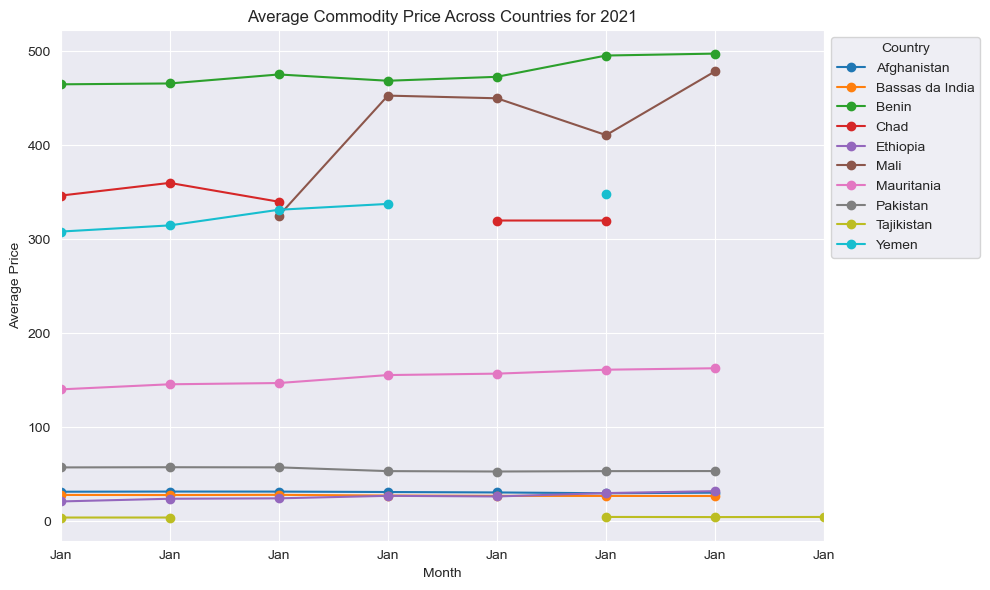

In [17]:
# Convert 'mp_year' and 'mp_month' to datetime format
df_wheat_m['mp_year'] = pd.to_datetime(df_wheat_m['mp_year'], format='%Y')
df_wheat_m['mp_month'] = pd.to_datetime(df_wheat_m['mp_month'], format='%m')

# Create a new datetime column combining 'mp_year' and 'mp_month'
df_wheat_m['full_date'] = pd.to_datetime(df_wheat_m['mp_year'].astype(str) + '-' + df_wheat_m['mp_month'].dt.strftime('%m'))

# Calculate the average price within a country for each month
monthly_country_avg = df_wheat_m.groupby(['adm0_name', 'full_date'])['mp_price_pu'].mean().reset_index()

# Filter the data for the maximum year
max_year = monthly_country_avg['full_date'].max().year
max_year_data = monthly_country_avg[monthly_country_avg['full_date'].dt.year == max_year]

# Pivot the data to create a DataFrame suitable for plotting
pivot_data = max_year_data.pivot(index='full_date', columns='adm0_name', values='mp_price_pu')

# Plotting
plt.figure(figsize=(10, 6))
pivot_data.plot(marker='o', linestyle='-', ax=plt.gca())

plt.title(f'Average Commodity Price Across Countries for {max_year}')
plt.xlabel('Month')
plt.ylabel('Average Price')

# Generate x-axis labels using the actual datetime objects
plt.xticks(pivot_data.index, pivot_data.index.strftime('%b'))

plt.grid(True)
plt.legend(title='Country', loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()


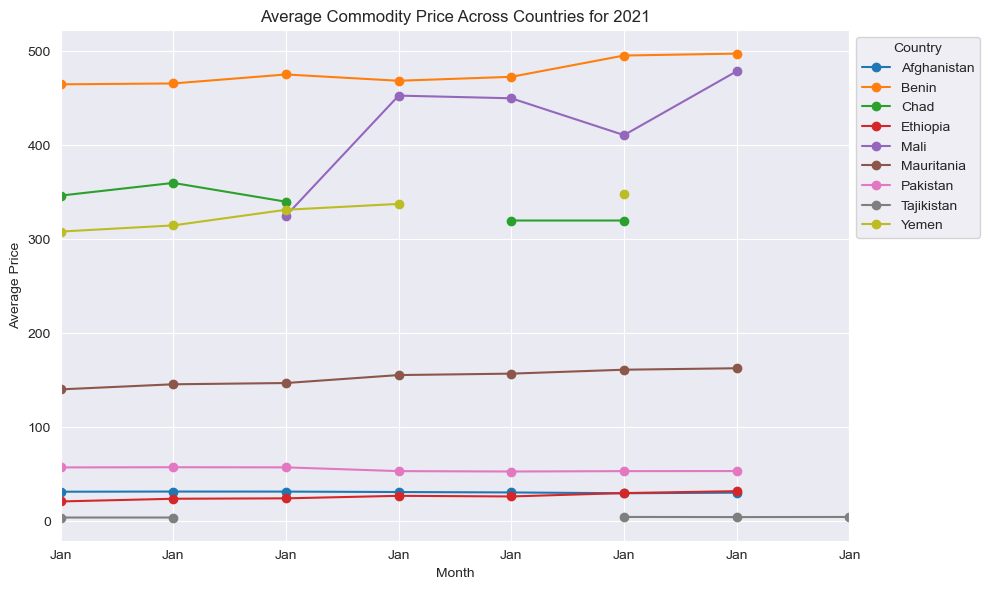

In [18]:
# Convert 'mp_year' and 'mp_month' to datetime format
df_wheat_m['mp_year'] = pd.to_datetime(df_wheat_m['mp_year'], format='%Y')
df_wheat_m['mp_month'] = pd.to_datetime(df_wheat_m['mp_month'], format='%m')

# Create a new datetime column combining 'mp_year' and 'mp_month'
df_wheat_m['full_date'] = pd.to_datetime(df_wheat_m['mp_year'].astype(str) + '-' + df_wheat_m['mp_month'].dt.strftime('%m'))

# Calculate the average price within a country for each month
monthly_country_avg = df_wheat_m.groupby(['adm0_name', 'full_date', 'latitude', 'longitude', 'geometry'])['mp_price_pu'].mean().reset_index()

# Filter the data for the maximum year
max_year = monthly_country_avg['full_date'].max().year
max_year_data = monthly_country_avg[monthly_country_avg['full_date'].dt.year == max_year]

# Pivot the data to create a DataFrame suitable for plotting
pivot_data = max_year_data.pivot(index='full_date', columns='adm0_name', values='mp_price_pu')

# Plotting
plt.figure(figsize=(10, 6))
pivot_data.plot(marker='o', linestyle='-', ax=plt.gca())

plt.title(f'Average Commodity Price Across Countries for {max_year}')
plt.xlabel('Month')
plt.ylabel('Average Price')

# Generate x-axis labels using the actual datetime objects
plt.xticks(pivot_data.index, pivot_data.index.strftime('%b'))

plt.grid(True)
plt.legend(title='Country', loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()


Seeing as the variation in prices in 2021 is not large, we can view the average price of retail wheat in 2021 across different countries on an interactive map, where the more expensive the average cost of wheat, the darker the hue.

In [19]:
import geopandas as gpd
import folium
from sklearn.preprocessing import MinMaxScaler
import branca

# Load the GeoDataFrame with country geometries
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
country_avg = monthly_country_avg.groupby(['adm0_name', 'latitude', 'longitude', 'geometry'])['mp_price_pu'].mean().reset_index()

# Drop rows with missing geometries
country_avg = country_avg.dropna(subset=['geometry'])

# Normalize commodity price values between 0 and 1
scaler = MinMaxScaler()
country_avg['mp_price_normalized'] = scaler.fit_transform(country_avg[['mp_price_pu']])

# Define custom colormap based on min and max values, with lower prices having the lightest shade
min_price = country_avg['mp_price_pu'].min()
max_price = country_avg['mp_price_pu'].max()
colormap = branca.colormap.LinearColormap(colors=['yellow', 'green'], vmin=min_price, vmax=max_price)

# Create a list of features in GeoJSON format
features = []
for _, row in country_avg.iterrows():
    feature = {
        "type": "Feature",
        "properties": {
            "adm0_name": row["adm0_name"],
            "mp_price_pu": row["mp_price_pu"],
            "mp_price_normalized": row["mp_price_normalized"]
        },
        "geometry": row["geometry"].__geo_interface__
    }
    features.append(feature)

# Construct the GeoJSON feature collection
geojson_dict = {
    "type": "FeatureCollection",
    "features": features
}

# Create an interactive map using Folium
m = folium.Map(location=[country_avg['latitude'].mean(), country_avg['longitude'].mean()], zoom_start=2)

# Add GeoJSON data to the map
folium.GeoJson(
    geojson_dict,
    name='geojson',
    style_function=lambda feature: {
        'fillColor': colormap(feature["properties"]["mp_price_pu"]),
        'color': 'black',
        'weight': 1,
        'fillOpacity': 0.9,
    },
    tooltip=folium.GeoJsonTooltip(fields=['adm0_name', 'mp_price_pu'], aliases=['Country', 'Price'])
).add_to(m)

# Add a legend for the commodity price
colormap.caption = 'Commodity Price'
colormap.add_to(m)

# Display the map in the notebook
display(m)


### 2. Chart information for the selected country and commodity over time to understand the behavior on the past, trends, seasonality, etc.

In [20]:
# Dataframe of Afghanistan // Wheat - Retail
df_afn_wheat = df[(df['adm0_name'] == 'Afghanistan') & (df['cm_name'] == 'Wheat - Retail')]

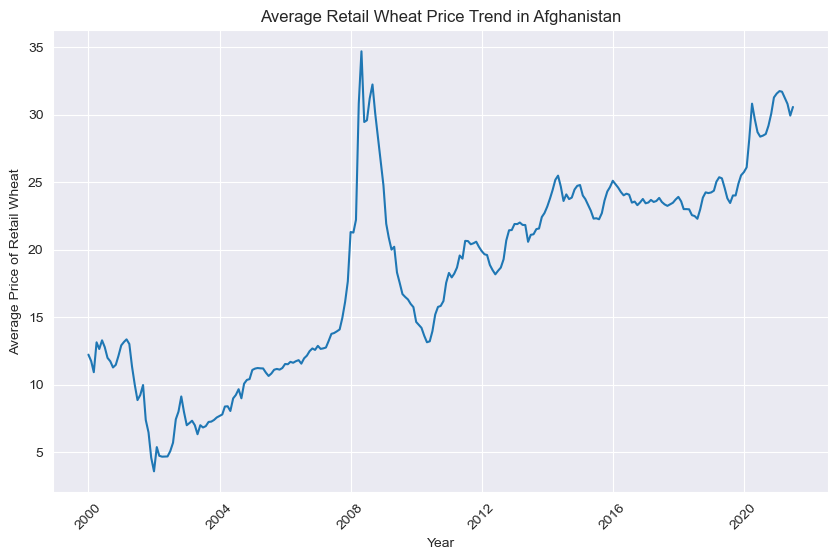

In [21]:
# Plot avg wheat prices in AFN
df_afn_avg_price = df_afn_wheat.groupby('start_of_month')['mp_price_pu'].mean().reset_index()

plt.figure(figsize=(10, 6))
plt.plot(df_afn_avg_price['start_of_month'], df_afn_avg_price['mp_price_pu'])
plt.xlabel('Year')
plt.ylabel('Average Price of Retail Wheat')
plt.title('Average Retail Wheat Price Trend in Afghanistan')
plt.xticks(rotation=45)  # Rotate x-axis labels
plt.grid(True)  # Add grid lines
plt.show()

### 3. Chart and compare prices of the selected commodity in the selected country, its neighboring countries, and the world.

To view all the countries that stock retail wheat, 

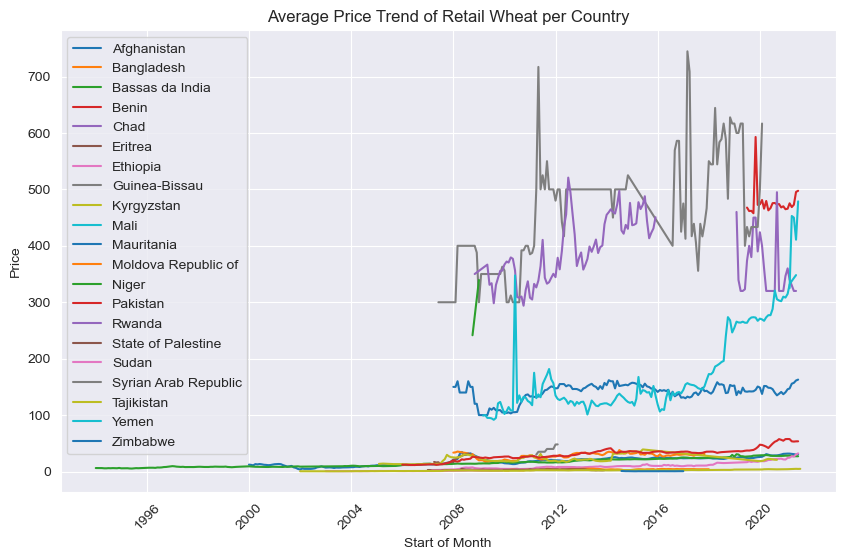

In [22]:
# Dataframe of countries with Wheat for Retail
df_wheat_rt = df[df['cm_name'] == 'Wheat - Retail']

# Plot for all countries with retailed wheat
# Groupby country and month
df_wheat_rt_avg = df_wheat_rt.groupby(['adm0_name', 'start_of_month'])['mp_price_pu'].mean().reset_index()

# Pivot the data to have countries as columns and start of month as index
pivot_df = df_wheat_rt_avg.pivot(index='start_of_month', columns='adm0_name', values='mp_price_pu')

plt.figure(figsize=(10, 6))

# Group the data by country and start of the month, and calculate the mean price
grouped_df = df_wheat_rt_avg.groupby(['adm0_name', 'start_of_month'])['mp_price_pu'].mean().reset_index()

# Plot the price of wheat for each country
countries = grouped_df['adm0_name'].unique()
for country in countries:
    country_df = grouped_df[grouped_df['adm0_name'] == country]
    plt.plot(country_df['start_of_month'], country_df['mp_price_pu'], label=country)

plt.xlabel('Start of Month')
plt.ylabel('Price')
plt.title('Average Price Trend of Retail Wheat per Country')
plt.legend()
plt.xticks(rotation=45)  # Rotate x-axis labels
plt.grid(True)  # Add grid lines
plt.show()

Comparing retail wheat prices in Afghanistan to the it's boardering countries

In [23]:
# Manually define country aliases
country_aliases = {
    'Bassas da India': ['France'],
    'State of Palestine': ['Palestine'],
    'Syrian Arab Republic': ['Syria'],
}
# Function to get country name from country code
def get_country_name(country_code):
    try:
        country = pycountry.countries.get(alpha_3=country_code)
        if country:
            return country.name
        else:
            return None
    except AttributeError:
        return None

# Function to get bordering countries for a given country
def get_bordering_countries(target_country):
    bordering_countries = set()

    try:
        if target_country in country_aliases:
            aliases = country_aliases[target_country]
            for alias in aliases:
                country_info = CountryInfo(alias)
                bordering_countries.update(country_info.borders())
        else:
            country_info = CountryInfo(target_country)
            bordering_countries.update(country_info.borders())
    except KeyError:
        print(f"Could not find country: {target_country}")

    country_names = [get_country_name(country_code) for country_code in bordering_countries]
    return [name for name in country_names if name is not None]

In [24]:
bordering_countries = get_bordering_countries('Afghanistan')
bordering_countries 

['Tajikistan',
 'China',
 'Pakistan',
 'Turkmenistan',
 'Uzbekistan',
 'Iran, Islamic Republic of']

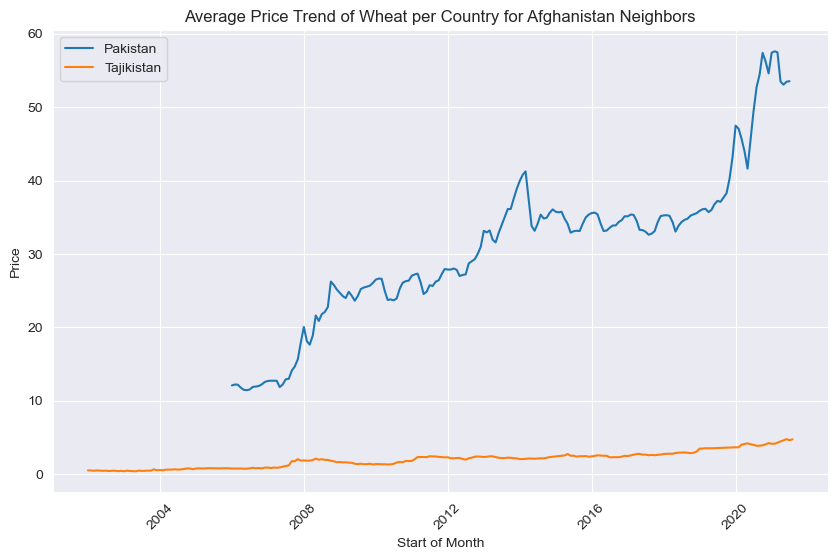

In [25]:
# Create dataframe with Afghan neighbors
df_afn_nbr = df[df['cm_name'].isin(['Wheat - Retail']) & df['adm0_name'].isin(bordering_countries)]

# Groupby country and month
df_nbr_avg = df_afn_nbr.groupby(['adm0_name', 'start_of_month'])['mp_price_pu'].mean().reset_index()

# Pivot the data to have countries as columns and start of month as index
pivot_df = df_nbr_avg.pivot(index='start_of_month', columns='adm0_name', values='mp_price_pu')
plt.figure(figsize=(10, 6))

# Group the data by country and start of the month, and calculate the mean price
grouped_df = df_afn_nbr.groupby(['adm0_name', 'start_of_month'])['mp_price_pu'].mean().reset_index()

# Plot the price of wheat for each country
countries = grouped_df['adm0_name'].unique()
for country in countries:
    country_df = grouped_df[grouped_df['adm0_name'] == country]
    plt.plot(country_df['start_of_month'], country_df['mp_price_pu'], label=country)

plt.xlabel('Start of Month')
plt.ylabel('Price')
plt.title('Average Price Trend of Wheat per Country for Afghanistan Neighbors')
plt.legend()
plt.xticks(rotation=45)  # Rotate x-axis labels if needed
plt.grid(True)  # Add grid lines
plt.show()

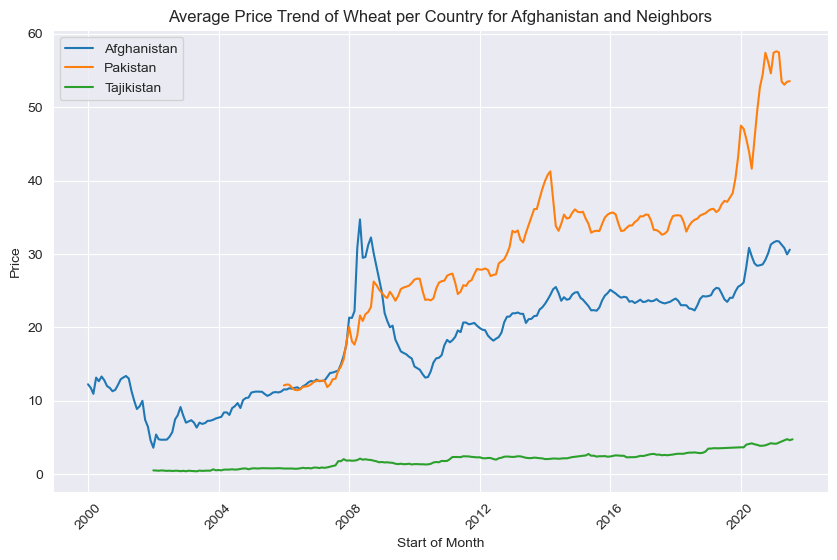

In [26]:
# Include Afghanistan in the list of countries
countries = list(set(bordering_countries) | set(['Afghanistan']))

# Create dataframe with Afghan neighbors that have retail wheat
df_afn_nbr = df[df['cm_name'].isin(['Wheat - Retail']) & df['adm0_name'].isin(countries)]



# Groupby country and month
df_nbr_avg = df_afn_nbr.groupby(['adm0_name', 'start_of_month'])['mp_price_pu'].mean().reset_index()

# Pivot the data to have countries as columns and start of month as index
pivot_df = df_nbr_avg.pivot(index='start_of_month', columns='adm0_name', values='mp_price_pu')
plt.figure(figsize=(10, 6))

# Group the data by country and start of the month, and calculate the mean price
grouped_df = df_afn_nbr.groupby(['adm0_name', 'start_of_month'])['mp_price_pu'].mean().reset_index()

# Plot the price of wheat for each country
for country in countries:
    country_df = grouped_df[grouped_df['adm0_name'] == country]
    if not country_df.empty:
        plt.plot(country_df['start_of_month'], country_df['mp_price_pu'], label=country)

plt.xlabel('Start of Month')
plt.ylabel('Price')
plt.title('Average Price Trend of Wheat per Country for Afghanistan and Neighbors')
plt.legend()
plt.xticks(rotation=45)  # Rotate x-axis labels if needed
plt.grid(True)  # Add grid lines
plt.show()



An alternative country to source affordable wheat for Pakistan and Afghanistan can be Tajikistan. However, we have wheat being sold on wholesale in other countries. 

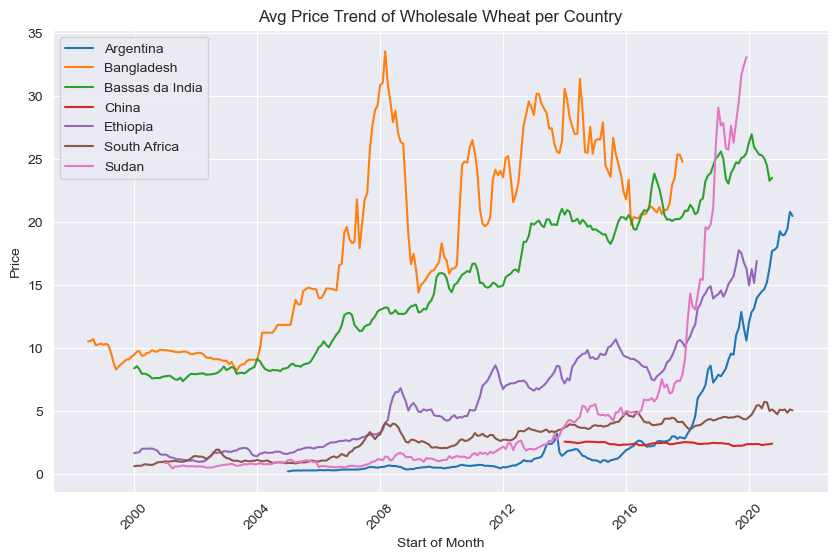

In [27]:
# Dataframe of countries with Wheat for Retail
df_wheat_wh = df[(df['cm_name'] == 'Wheat - Wholesale')]

# Plot for all countries with retailed wheat
# Groupby country and month
df_wheat_wh_avg = df_wheat_wh.groupby(['adm0_name', 'start_of_month'])['mp_price_pu'].mean().reset_index()

# Calculate the mean average mp_price_pu for Afghanistan and Wheat - Retail
max_avg_price_afn_wheat_retail = df_afn_avg_price.mp_price_pu.max()
# Filter the data for the graph using the same condition as the function
df_wheat_wh_avg = df_wheat_wh_avg[df_wheat_wh_avg['mp_price_pu'] < max_avg_price_afn_wheat_retail]

# Pivot the data to have countries as columns and start of month as index
pivot_df = df_wheat_wh_avg.pivot(index='start_of_month', columns='adm0_name', values='mp_price_pu')

plt.figure(figsize=(10, 6))

# Group the data by country and start of the month, and calculate the mean price
grouped_df = df_wheat_wh_avg.groupby(['adm0_name', 'start_of_month'])['mp_price_pu'].mean().reset_index()

# Plot the price of wheat for each country
countries = grouped_df['adm0_name'].unique()
for country in countries:
    country_df = grouped_df[grouped_df['adm0_name'] == country]
    plt.plot(country_df['start_of_month'], country_df['mp_price_pu'], label=country)

plt.xlabel('Start of Month')
plt.ylabel('Price')
plt.title('Avg Price Trend of Wholesale Wheat per Country')
plt.legend()
plt.xticks(rotation=45)  # Rotate x-axis labels
plt.grid(True)  # Add grid lines
plt.show()

### 4. Where would you recommend the selected country to source the selected commodity from? Include and mention all necessary hypotheses when required.

China

Hypothesis: Wholesale wheat prices are lower in China due to factors such as local production, transportation costs, trade agreements, or subsidies. Being a boardering country, transport costs from China to Afghanistan will be low.

other information you would need to provide a forecast for next month/ the next 12 months? Please also explain what the sources of uncertainty would be for such a forecast and how you could estimate the uncertainty of the forecast (e.g., through a confidence interval).


To provide a forecast for the next month or the next 12 months using data from 2000 to 2022 December on food prices in countries, you would need the following additional information:

1. Recent Data: Obtain the most up-to-date data available for food prices. Having data for the current month or the past few months will help capture the latest trends and changes in food prices.

2. Economic Indicators: Gather relevant economic indicators that can influence food prices, such as GDP growth, inflation rates, exchange rates, interest rates, and agricultural production data. These indicators provide insights into the macroeconomic conditions and can help identify potential drivers of food price fluctuations.

3. Market-specific Factors: Consider market-specific factors that impact food prices, such as supply and demand dynamics, market competition, transportation costs, storage capacity, and infrastructure. Changes in these factors can affect the availability and cost of food, thus influencing prices.

4. Weather and Climate Data: Collect weather and climate data for the regions or countries involved in the food market. Weather conditions, including rainfall, temperature, droughts, and natural disasters, can significantly impact agricultural production and subsequently affect food prices.

5. Trade Policies and Agreements: Monitor changes in government policies, trade agreements, and regulations related to food imports and exports. Adjustments in tariffs, quotas, subsidies, or trade restrictions can affect food prices by altering the supply-demand balance.

6. Consumer Behavior and Preferences: Analyze consumer behavior, income levels, population growth, dietary shifts, and cultural factors that may impact food consumption patterns. Changes in consumer preferences and purchasing power can influence food prices for specific categories or commodities.

Sources of Uncertainty and Estimating Forecast Uncertainty:

Forecasting food prices involves inherent uncertainty due to various factors. Some sources of uncertainty include:

1. Volatility in Commodities: Food prices can be influenced by the volatility of underlying commodity markets, such as grain prices, oil prices (affecting transportation costs), and other key agricultural inputs. These market fluctuations introduce uncertainty into food price forecasts.

2. Geopolitical Events: Political instability, conflicts, or trade disputes can disrupt food supply chains and impact prices. Geopolitical events are difficult to predict, and their outcomes can introduce considerable uncertainty into food price forecasts.

3. Climate Variability: Weather patterns and natural disasters, such as droughts, floods, or extreme weather events, can significantly affect crop yields and agricultural production. The uncertainty associated with climate variability can make food price forecasts challenging.

4. Unforeseen Events: Unexpected events, such as disease outbreaks (e.g., pandemics affecting labor availability or livestock health), technological disruptions, or policy changes, can introduce uncertainty into food markets and price forecasts.

To estimate the uncertainty of the forecast, one approach is to use confidence intervals. By applying statistical techniques, you can calculate upper and lower bounds around the forecasted food prices, providing a range of potential outcomes. Confidence intervals provide a measure of uncertainty and indicate the level of confidence in the forecast.

Additionally, scenario analysis can be employed to assess the uncertainty. By considering different scenarios based on varying assumptions and key factors, you can evaluate a range of potential outcomes and their associated risks. Sensitivity analysis can also help identify the key variables that have a significant impact on the forecasted food prices, allowing for a better understanding of the uncertainty involved.

It's important to note that the accuracy of the forecasted food prices will depend on the quality of the data, the chosen forecasting models/methods, and the assumptions made. Regularly updating the forecast with new data and monitoring changes in relevant factors will help adapt and refine the forecast as conditions evolve, further reducing uncertainty.

## Conclusion

Questions to Answer
1. Of the countries that sell retail wheat, how do their prices compare in the most recent year?
 • *Benin, Guinea-Bissau and Mali had the most expensive rates for retail wheat in 2021 based on how dark the green is.

2. For the selected country (Afghanistan) and commodity (Wheat-Retail), what bhavior can be observed?
• *The price seems to have a general positive linear growth with some spikes and dips in price. The most significant spike happened between 2008 and 2009. From reseach, Afghanistan witnessed several significant developments related to the ongoing conflict, political transitions, and international involvement in this period. Intense fighting continued between Afghan and international coalition forces on one side and various insurgent groups, primarily the Taliban and other militant factions, on the other. The violence escalated in many parts of the country, especially in the southern and eastern provinces. 

3. How does the price of the commodity compare to other countries selling it over time?
• *Guinea Bissau, Benin and Rwanda have the highest prices between 2010 to 2020. Mali soon joined the ranks in 2020 and 2021. The countries with the lowest prices include Zimbabwe, Sudan, Tajikistan, and Ethiopia.

4. What is an alternative source of the commodity for the select country?
• *China

*Hypothesis: Wholesale wheat prices are lower in China due to factors such as local production, transportation costs, trade agreements, or subsidies. Being a boardering country, transport costs from China to Afghanistan will be low.

5. What additional information can be helpful to forecast the price of the commodity in the next month? year? 5 years?
• *To provide a forecast for the next month or the next 12 months using data from 2000 to 2022 December on food prices in countries, you would need the following additional information:

1. Recent Data: Obtain the most up-to-date data available for food prices. Having data for the current month or the past few months will help capture the latest trends and changes in food prices.

2. Economic Indicators: Gather relevant economic indicators that can influence food prices, such as GDP growth, inflation rates, exchange rates, interest rates, and agricultural production data. These indicators provide insights into the macroeconomic conditions and can help identify potential drivers of food price fluctuations.

3. Market-specific Factors: Consider market-specific factors that impact food prices, such as supply and demand dynamics, market competition, transportation costs, storage capacity, and infrastructure. Changes in these factors can affect the availability and cost of food, thus influencing prices.

4. Weather and Climate Data: Collect weather and climate data for the regions or countries involved in the food market. Weather conditions, including rainfall, temperature, droughts, and natural disasters, can significantly impact agricultural production and subsequently affect food prices.

5. Trade Policies and Agreements: Monitor changes in government policies, trade agreements, and regulations related to food imports and exports. Adjustments in tariffs, quotas, subsidies, or trade restrictions can affect food prices by altering the supply-demand balance.

6. Consumer Behavior and Preferences: Analyze consumer behavior, income levels, population growth, dietary shifts, and cultural factors that may impact food consumption patterns. Changes in consumer preferences and purchasing power can influence food prices for specific categories or commodities.

• *Sources of Uncertainty and Estimating Forecast Uncertainty:

• *Forecasting food prices involves inherent uncertainty due to various factors. Some sources of uncertainty include:

1. Volatility in Commodities: Food prices can be influenced by the volatility of underlying commodity markets, such as grain prices, oil prices (affecting transportation costs), and other key agricultural inputs. These market fluctuations introduce uncertainty into food price forecasts.

2. Geopolitical Events: Political instability, conflicts, or trade disputes can disrupt food supply chains and impact prices. Geopolitical events are difficult to predict, and their outcomes can introduce considerable uncertainty into food price forecasts.

3. Climate Variability: Weather patterns and natural disasters, such as droughts, floods, or extreme weather events, can significantly affect crop yields and agricultural production. The uncertainty associated with climate variability can make food price forecasts challenging.

4. Unforeseen Events: Unexpected events, such as disease outbreaks (e.g., pandemics affecting labor availability or livestock health), technological disruptions, or policy changes, can introduce uncertainty into food markets and price forecasts.

• *To estimate the uncertainty of the forecast, one approach is to use confidence intervals. By applying statistical techniques, you can calculate upper and lower bounds around the forecasted food prices, providing a range of potential outcomes. Confidence intervals provide a measure of uncertainty and indicate the level of confidence in the forecast.

• *Additionally, scenario analysis can be employed to assess the uncertainty. By considering different scenarios based on varying assumptions and key factors, you can evaluate a range of potential outcomes and their associated risks. Sensitivity analysis can also help identify the key variables that have a significant impact on the forecasted food prices, allowing for a better understanding of the uncertainty involved.

• *It's important to note that the accuracy of the forecasted food prices will depend on the quality of the data, the chosen forecasting models/methods, and the assumptions made. Regularly updating the forecast with new data and monitoring changes in relevant factors will help adapt and refine the forecast as conditions evolve, further reducing uncertainty.

## References

  1. [Humdata](https://data.humdata.org/dataset/wfp-food-prices)
  2. [Natural Earth](https://www.naturalearthdata.com/)